Rodrigo García Salado

---
### PRÁCTICA 2
---

Ponemos los imports

In [9]:
#imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import pickle

Importamos el archivo

In [10]:
# Cargamos el archivo
data_df = pd.read_csv("Practica2/semillas.csv") 

Ahora observamos cuantos y qué tipo de datos vamos a estar tratando


In [11]:

print('The shape of the data table is:')
print('===============================')
print(data_df.shape)
print()

print('The types of the attributes are:')
print('================================')
data_df.info()

print()

print('How many missing values per attribute:')
print('======================================')
print(data_df.isnull().sum())

print()

print('Fraction of missing values per attribute:')
print('======================================')
print(data_df.isnull().mean())


The shape of the data table is:
(210, 8)

The types of the attributes are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        210 non-null    float64
 1   perimetro   210 non-null    float64
 2   compacidad  210 non-null    float64
 3   longitud    210 non-null    float64
 4   anchura     210 non-null    float64
 5   asimetria   210 non-null    float64
 6   surco       210 non-null    float64
 7   clase       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB

How many missing values per attribute:
area          0
perimetro     0
compacidad    0
longitud      0
anchura       0
asimetria     0
surco         0
clase         0
dtype: int64

Fraction of missing values per attribute:
area          0.0
perimetro     0.0
compacidad    0.0
longitud      0.0
anchura       0.0
asimetria     0.0
surco         0.0
clase     

In [12]:
SEMILLA = 100478705


# Separar características y etiquetas
X = data_df.drop(columns=['clase']) 
y = data_df['clase']

# Lista de scalers a comparar
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler()
}



creamos la figura para comparar


StandardScaler
Varianza explicada por componente 1: 0.7187
Varianza explicada por componente 2: 0.1711
Varianza total explicada (2 componentes): 0.8898


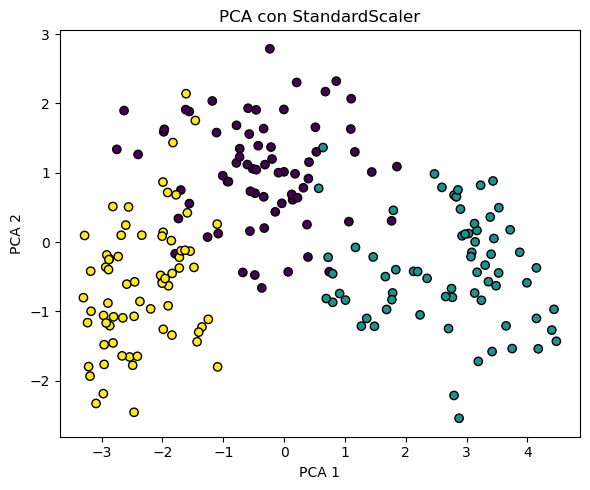


MinMaxScaler
Varianza explicada por componente 1: 0.7890
Varianza explicada por componente 2: 0.1291
Varianza total explicada (2 componentes): 0.9181


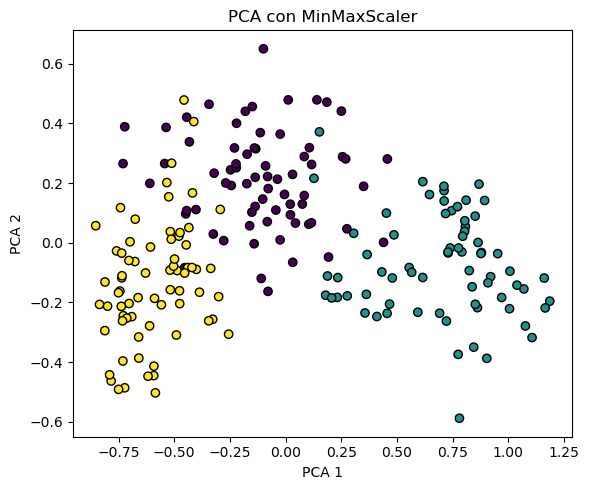


RobustScaler
Varianza explicada por componente 1: 0.6695
Varianza explicada por componente 2: 0.1996
Varianza total explicada (2 componentes): 0.8691


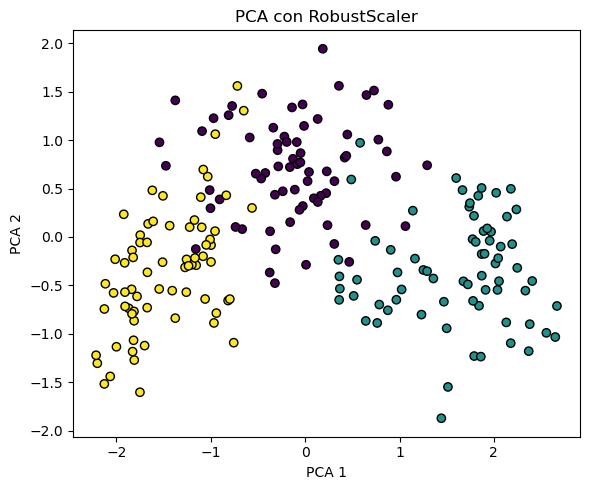

In [13]:
# Iterar sobre los scalers y graficar uno a uno
for name, scaler in scalers.items():
    # Crear pipeline: scaler + PCA con semilla
    pipeline = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2, random_state = SEMILLA))
    ])

    # Transformar los datos
    X_pca = pipeline.fit_transform(X)
    pca = pipeline.named_steps['pca']  # acceder al PCA para consultar la varianza

    # Varianza explicada
    explained_var = pca.explained_variance_ratio_
    total_explained = np.sum(explained_var)

    print(f"\n{name}")
    print(f"Varianza explicada por componente 1: {explained_var[0]:.4f}")
    print(f"Varianza explicada por componente 2: {explained_var[1]:.4f}")
    print(f"Varianza total explicada (2 componentes): {total_explained:.4f}")

    # Graficar
    plt.figure(figsize=(6, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k')
    plt.title(f'PCA con {name}')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.tight_layout()
    plt.show()

In [14]:
# Escalado con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reducción con PCA a 2 componentes
pca = PCA(n_components=2, random_state=SEMILLA)
X_pca = pca.fit_transform(X_scaled)

### Aplicamos las reglas de clustering

Primero medimos el numero de clusters

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=SEMILLA)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_pca, kmeans.labels_))





Medimos la inercia mediante el metodo del codo

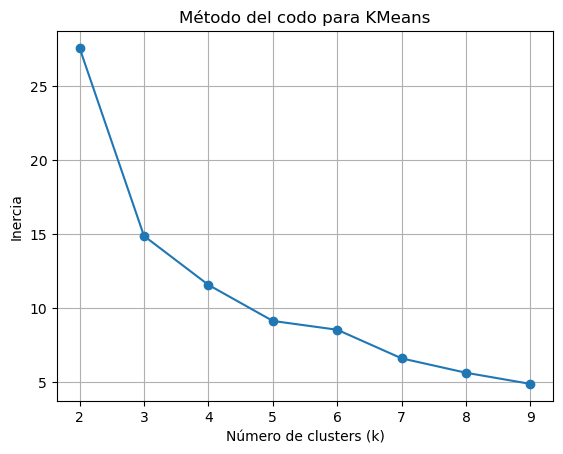

In [16]:
# Gráfico del método del codo
plt.figure()
plt.plot(K, inertia, 'o-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para KMeans')
plt.grid()
plt.show()

Y la distancia entre un cluster y otro por medio del coeficiente de silueta

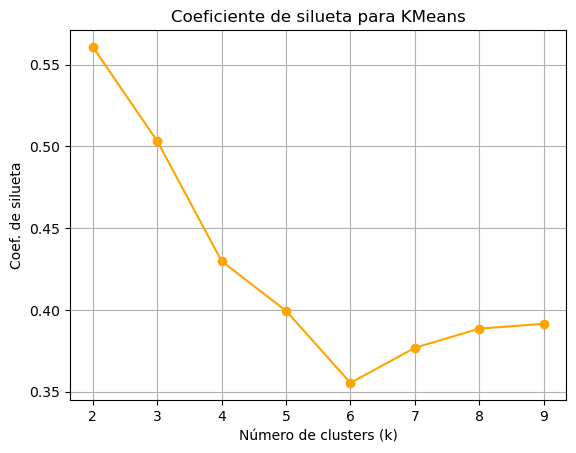

In [17]:
# Gráfico del coeficiente de silueta
plt.figure()
plt.plot(K, silhouette, 'o-', color='orange')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Coef. de silueta')
plt.title('Coeficiente de silueta para KMeans')
plt.grid()
plt.show()


Aunque el valor más alto del coeficiente de silueta se obtiene con k=2, el método del codo muestra claramente un punto de inflexión en k=3.

Además, el valor de silueta en k=3 sigue siendo razonablemente alto, lo que sugiere una buena separación entre los clusters. Por tanto, optamos por aplicar KMeans con k=3

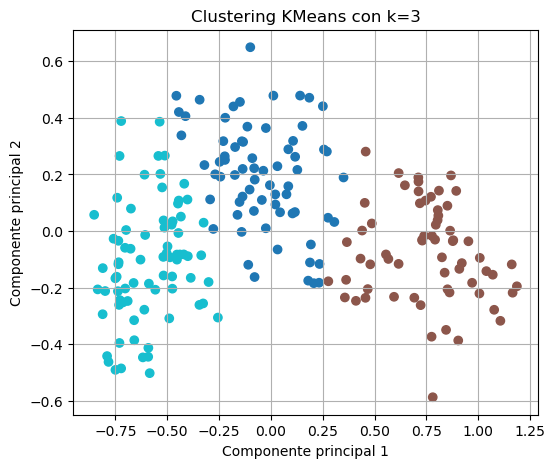

In [ ]:
k_opt = 3

kmeans = KMeans(n_clusters=k_opt, random_state=SEMILLA)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualizar los clusters encontrados
plt.figure(figsize=(6, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10')
plt.title(f'Clustering KMeans con k={k_opt}')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid()
plt.show()
